<a href="https://colab.research.google.com/github/Bassana07/devoir-theorie-graphe-s5/blob/main/Devoir%20theorie%20des%20graphes%20groupe%2011.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROJET SCOLAIRE - THEORIE DES GRAPHES**
============================================================

# **SOMMAIRE**

# I. Configuration de l’environnement
# II. Modélisation mathématique
# III. Fonctions usuelles pour les graphes
    III.1. creer_graphes
    III.2. visualiser_graphe
    III.3. dessiner_aretes
    III.4. dessiner_noeuds
    III.5. dessiner_labels
    III.6. hierarchy_pos
    III.7. afficher_legende
    III.8. finaliser_affichage
# IV. Fonctions usuelles pour le traitement et l’analyse
    IV.1. kruskal
    IV.2. determiner_cluster_radio
    IV.3. calculer_distance_cout
    IV.4. construire_solution_hybride
    IV.5. resultats_analyse
# V. Étude du projet et résolution


# I. Configuration de l’environnement


In [163]:
# Importations
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import FancyBboxPatch, Circle
from matplotlib.patches import Patch
import warnings
from matplotlib.lines import Line2D

# Parametrage pour l'affichage
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# Couleur de texte
RED_BOLD = "\033[1;31m"
BLACK_BOLD = "\033[1;30m"
RESET = "\033[0m"

# II. Modélisation mathématique



In [164]:
def modelisation():
    """
    Initialise les informations des lycées, la matrice de distances
    et les paramètres de coût/contrainte pour la solution hybride.

    Returns:
        lycees_info (dict): Informations sur chaque lycée
        labels (list): Liste des lycées ['L0', 'L1', ...]
        distance_matrix (np.array): Matrice des distances complètes (km)
        COUT_FIBRE_PAR_KM (int)
        COUT_RADIO_PAIRE (int)
        SEUIL_RADIO (float)
    """
    # Informations des lycées
    lycees_info = {
        'L0': {'nom': 'Serveur central', 'distance_centre': 0, 'eleves': 0},
        'L1': {'nom': 'Lycée Bogodogo', 'distance_centre': 3, 'eleves': 2500},
        'L2': {'nom': 'Lycée Zinda', 'distance_centre': 4, 'eleves': 3000},
        'L3': {'nom': 'Lycée Mandela', 'distance_centre': 6, 'eleves': 2000},
        'L4': {'nom': 'Lycée Municipal', 'distance_centre': 2, 'eleves': 1800},
        'L5': {'nom': 'Lycée Scientifique', 'distance_centre': 8, 'eleves': 1200},
        'L6': {'nom': 'Lycée Mixte', 'distance_centre': 5, 'eleves': 2200}
    }

    # Labels
    labels = ['L0', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6']

    # Matrice de distances complète (km)
    distance_matrix = np.array([
        [0, 3, 4, 6, 2, 8, 5],  # L0
        [3, 0, 3, 5, 4, 2, 7],  # L1
        [4, 3, 0, 2, 3, 4, 6],  # L2
        [6, 5, 2, 0, 3, 5, 4],  # L3
        [2, 4, 3, 3, 0, 3, 5],  # L4
        [8, 2, 4, 5, 3, 0, 6],  # L5
        [5, 7, 6, 4, 5, 6, 0]   # L6
    ])

    # Affichage
    df_distances = pd.DataFrame(distance_matrix, index=labels, columns=labels)

    # Coûts et seuil radio
    COUT_FIBRE_PAR_KM = 500_000   # FCFA
    COUT_RADIO_PAIRE = 2_000_000  # FCFA
    SEUIL_RADIO = 5                # km

    return lycees_info, labels, distance_matrix, COUT_FIBRE_PAR_KM, COUT_RADIO_PAIRE, SEUIL_RADIO

# III. Fonctions usuelles pour les graphes


    III.1. creer_graphes
   

In [165]:
def creer_graphes(labels, lycees_info, distance_matrix, type_graphe='complet',
                   cluster_radio=None, edges_fibre_kept=None,
                   ):
    """
    Crée des graphes selon le type demandé : complet, ACM ou hybride.

    Parameters:
        labels (list): Liste des lycées ['L0', 'L1', ...]
        lycees_info (dict): Infos sur les lycées
        distance_matrix (np.array): Matrice des distances (km)
        cluster_radio (list, optional): Lycées du cluster radio (pour hybride)
        edges_fibre_kept (list, optional): Arêtes fibre conservées (pour hybride)
        type_graphe (str): 'complet', 'acm', 'hybride' ou 'tous'

    Returns:
        Selon type_graphe :
        - 'complet' : G_complet, aretes_completes
        - 'acm' : G_acm
        - 'hybride' : G_hybride
    """

    # ================================
    # Graphe complet
    # ================================
    G_complet = nx.Graph()
    for node in labels:
        G_complet.add_node(node, nom=lycees_info[node]['nom'])

    aretes_completes = []
    n = len(labels)
    for i in range(n):
        for j in range(i + 1, n):
            distance = distance_matrix[i][j]
            G_complet.add_edge(labels[i], labels[j], weight=distance)
            aretes_completes.append((labels[i], labels[j], distance))

    # ================================
    # Graphe ACM vide
    # ================================
    acm_edges = kruskal(G_complet)
    G_acm = nx.Graph()
    for node in G_complet.nodes():
        G_acm.add_node(node)
    for u, v, d in acm_edges:
        G_acm.add_edge(u, v, weight=d)

    # ================================
    # Graphe hybride
    # ================================
    G_hybride = nx.Graph()
    if cluster_radio and edges_fibre_kept:
        for node in labels:
            G_hybride.add_node(node)
        # Radio
        for i, u in enumerate(cluster_radio):
            for v in cluster_radio[i + 1:]:
                idx1, idx2 = labels.index(u), labels.index(v)
                dist = distance_matrix[idx1][idx2]
                G_hybride.add_edge(u, v, weight=dist, type='radio')
        # Fibre
        for u, v, d in edges_fibre_kept:
            G_hybride.add_edge(u, v, weight=d, type='fibre')

    # ================================
    # Retour selon type
    # ================================
    if type_graphe == 'complet':
        return G_complet, aretes_completes
    elif type_graphe == 'acm':
        return G_acm
    elif type_graphe == 'hybride':
        return G_hybride
    else:
        raise ValueError("Le type graphe doit être : 'complet', 'acm', 'hybride'")

    III.2. visualiser_graphe
  

In [166]:
def visualiser_graphe(Graphe, type_graphe, root=None):

    """
    Génère la visualisation du graphe selon son type
    (complet, ACM ou hybride) et calcule la position des sommets.

    Parameters:
        Graphe (nx.Graph): Graphe à visualiser
        type_graphe (str): Type du graphe ('complet', 'acm', 'hybride')
        root (str, optional): Nœud racine pour la hiérarchie (ACM)

    Returns:
        fig (matplotlib.figure.Figure): Figure matplotlib
        ax (matplotlib.axes.Axes): Axe de la figure
        pos (dict): Dictionnaire des positions des sommets
    """

    if type_graphe == "complet":
        fig, ax = plt.subplots(figsize=(14, 10))
        pos = nx.spring_layout(Graphe, seed=42, k=2)

    elif type_graphe == "acm":
        fig, ax = plt.subplots(figsize=(14, 10))
        pos = hierarchy_pos(Graphe, root=root)
        # Vérifier et compléter les positions manquantes avec spring_layout
        missing_nodes = set(Graphe.nodes()) - set(pos.keys())
        if missing_nodes:
            extra_pos = nx.spring_layout(Graphe.subgraph(missing_nodes), seed=42)
            pos.update(extra_pos)

    elif type_graphe == "hybride":
        fig, ax = plt.subplots(figsize=(16, 12))

        centre = ['L0']
        radio = [n for n, d in Graphe.nodes(data=True) if d.get('type') == 'radio']
        fibre = [n for n, d in Graphe.nodes(data=True) if d.get('type') == 'fibre']

        shells = [centre, radio, fibre]

        pos_shell = nx.shell_layout(Graphe, shells)
        pos = nx.spring_layout(Graphe, pos=pos_shell, seed=42, k=1.2)


    else:
        raise ValueError("Le type de graphe doit être 'complet', 'hybride' ou 'acm'")

    return fig, ax, pos

    III.3. dessiner_aretes

In [167]:
def dessiner_aretes(Graphe, pos, type_graphe):
    """
    Dessine les arêtes du graphe selon son type
    (complet, ACM ou hybride) avec un style adapté
    afin d'améliorer la lisibilité de la visualisation.

    Parameters:
        Graphe (nx.Graph): Graphe à afficher
        pos (dict): Positions des sommets
        type_graphe (str): Type du graphe ('complet', 'acm', 'hybride')
    """

    if type_graphe == "complet":
        edges = Graphe.edges()
        weights = [Graphe[u][v]['weight'] for u, v in edges]

        nx.draw_networkx_edges(
            Graphe, pos,
            width=3,
            alpha=0.3,
            edge_color=weights,
            edge_cmap=plt.cm.RdYlGn_r,
            edge_vmin=0,
            edge_vmax=10
        )

    elif type_graphe == "acm":
        nx.draw_networkx_edges(
            Graphe, pos,
            width=4,
            alpha=0.9,
            edge_color='#3498db'
        )

    elif type_graphe == "hybride":
        radio_edges = [(u, v) for u, v, d in Graphe.edges(data=True) if d.get('type') == 'radio']
        fibre_edges = [(u, v) for u, v, d in Graphe.edges(data=True) if d.get('type') == 'fibre']

        nx.draw_networkx_edges(
            Graphe, pos,
            edgelist=radio_edges,
            width=4,
            alpha=0.6,
            edge_color='#f39c12',
            style='dashed',
            label='Radio'
        )

        nx.draw_networkx_edges(
            Graphe, pos,
            edgelist=fibre_edges,
            width=4,
            alpha=0.7,
            edge_color='#3498db',
            label='Fibre'
        )

    else:
        raise ValueError("Le type de graphe doit être 'complet', 'hybride' ou 'acm'")

    III.4. dessiner_noeuds
    

In [168]:
def dessiner_noeuds(Graphe, pos, type_graphe, cluster_radio=None):
    """
    Dessine les nœuds du graphe selon le type de représentation choisi.

    Paramètres :
    - Graphe : graphe NetworkX à afficher
    - pos : dictionnaire des positions des nœuds
    - type_graphe : type de graphe à dessiner ('complet', 'acm' ou 'hybride')
    - cluster_radio : ensemble ou liste de nœuds appartenant au cluster radio (optionnel)
    """

    if type_graphe == "complet":
        nx.draw_networkx_nodes(
            Graphe, pos,
            node_size=2000,
            node_color=['#FF6B6B' if n == 'L0' else '#4ECDC4' for n in Graphe.nodes()],
            edgecolors='black',
            linewidths=2
        )

    elif type_graphe == "acm":
        nx.draw_networkx_nodes(
            Graphe, pos,
            node_size=2500,
            node_color=['#e74c3c' if n == 'L0' else '#2ecc71' for n in Graphe.nodes()],
            edgecolors='black',
            linewidths=2
        )

    elif type_graphe == "hybride":
        node_colors = []
        for n in Graphe.nodes():
            if n == 'L0':
                node_colors.append('#e74c3c')
            elif cluster_radio and n in cluster_radio:
                node_colors.append('#f39c12')
            else:
                node_colors.append('#2ecc71')

        nx.draw_networkx_nodes(
            Graphe, pos,
            node_size=2500,
            node_color=node_colors,
            edgecolors='black',
            linewidths=2
        )

        nx.draw_networkx_labels(
            Graphe, pos,
            font_size=12,
            font_weight='bold',
            font_color='white'
        )

    else:
        raise ValueError("Le type graphe doit être 'complet', 'hybride' ou 'acm'")

    III.5. dessiner_labels
   

In [169]:
def dessiner_labels(Graphe, pos, type_graphe, acm_edges=None):
    """
    Dessine les étiquettes (labels) des nœuds et des arêtes
    selon le type de graphe affiché.

    Paramètres :
    - Graphe : graphe NetworkX à afficher
    - pos : dictionnaire des positions des nœuds
    - type_graphe : type de graphe ('complet', 'acm' ou 'hybride')
    - acm_edges : liste des arêtes de l'ACM avec leurs poids (optionnel)
    """

    if type_graphe == "complet":
        # Labels des nœuds
        nx.draw_networkx_labels(
            Graphe, pos,
            font_size=12,
            font_weight='bold'
        )

        # Labels des arêtes (distances)
        edge_labels = nx.get_edge_attributes(Graphe, 'weight')
        nx.draw_networkx_edge_labels(
            Graphe, pos,
            edge_labels,
            font_size=8
        )

    elif type_graphe == "acm":
        # Labels des nœuds
        nx.draw_networkx_labels(
            Graphe, pos,
            font_size=12,
            font_weight='bold',
            font_color='white'
        )

        # Labels des arêtes
        edge_labels_acm = {
            (u, v): f"{d:.1f} km" for u, v, d in acm_edges
        }
        nx.draw_networkx_edge_labels(
            Graphe, pos,
            edge_labels_acm,
            font_size=10,
            font_weight='bold'
        )

    elif type_graphe == "hybride":
        # Labels des arêtes
        edge_labels_hybride = {}
        for u, v, data in Graphe.edges(data=True):
            edge_labels_hybride[(u, v)] = f"{data['weight']}km"

        nx.draw_networkx_edge_labels(
            Graphe, pos,
            edge_labels_hybride,
            font_size=9
        )

    else:
        raise ValueError("type_graphe doit être 'complet', 'hybride' ou 'acm'")

    III.6. hierarchy_pos
   

In [170]:
def hierarchy_pos(G, root=None, width=1.0, vert_gap=0.15, vert_loc=0, xcenter=0.5):
    """
    Calcule les positions des nœuds d'un graphe arborescent
    selon une disposition hiérarchique (sans croisement).

    Paramètres :
    - G : graphe NetworkX (supposé être un arbre ou proche d'un arbre)
    - root : nœud racine de l'arbre (par défaut, le premier nœud du graphe)
    - width : largeur totale de la représentation
    - vert_gap : espacement vertical entre deux niveaux
    - vert_loc : position verticale initiale de la racine
    - xcenter : position horizontale centrale (non utilisée ici directement)

    Retour :
    - pos : dictionnaire {nœud: (x, y)} utilisable par NetworkX
    """

    if root is None:
        root = list(G.nodes())[0]

    def _hierarchy_pos(G, root, left, right, vert_loc, pos, parent=None):
        pos[root] = ((left + right) / 2, vert_loc)

        children = list(G.neighbors(root))
        if parent is not None:
            children.remove(parent)

        if len(children) != 0:
            dx = (right - left) / len(children)
            nextx = left
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(
                    G, child,
                    nextx - dx, nextx,
                    vert_loc - vert_gap,
                    pos, root
                )
        return pos

    return _hierarchy_pos(G, root, 0, width, vert_loc, {})

    III.7. afficher_legende
   

In [171]:
def afficher_legende(type_graphe, cluster_radio=None):
    """
    Affiche la légende selon le type de graphe.

    Parameters:
        type_graphe (str): 'complet', 'acm' ou 'hybride'
        cluster_radio (list, optional): requis pour le graphe hybride
    """

    legend_elements = []

    # =====================
    # GRAPHE COMPLET
    # =====================
    if type_graphe == "complet":
        legend_elements = [
            Patch(facecolor='#FF6B6B', label='Serveur Central (L0)'),
            Patch(facecolor='#4ECDC4', label='Lycée'),
            Line2D(
                [], [], color='gray', linewidth=3, alpha=0.3,
                label='Distance (km)'
            )
        ]

    # =====================
    # ACM
    # =====================
    elif type_graphe == "acm":
        legend_elements = [
            Patch(facecolor='#e74c3c', label='Serveur Central (L0)'),
            Patch(facecolor='#2ecc71', label='Lycée'),
            Line2D(
                [], [], color='#3498db', linewidth=4,
                label='Liaison Fibre (ACM)'
            )
        ]

    # =====================
    # HYBRIDE
    # =====================
    elif type_graphe == "hybride":
        if cluster_radio is None:
            raise ValueError("cluster_radio est requis pour le graphe hybride")

        legend_elements = [
            Patch(facecolor='#e74c3c', label='Serveur Central (L0)'),
            Patch(facecolor='#2ecc71', label='Lycée (Fibre)'),
            Patch(facecolor='#f39c12', label=f'Cluster Radio {cluster_radio}'),
            Line2D(
                [], [], color='#3498db', linewidth=4,
                label='Connexion Fibre'
            ),
            Line2D(
                [], [], color='#f39c12', linewidth=4,
                linestyle='dashed',
                label='Connexion Radio'
            )
        ]

    else:
        raise ValueError("type_graphe doit être 'complet', 'acm' ou 'hybride'")

    plt.legend(
        handles=legend_elements,
        loc='upper right',
        fontsize=13,
        frameon=True
    )

    III.8. finaliser_affichage


In [172]:
def finaliser_affichage(type_graphe,
                        distance_totale_acm=None,
                        cout_total_hybride=None,
                        economie=None,
                        economie_pct=None):

    """
    Finalise l'affichage d'un graphe en ajoutant le titre,
    en masquant les axes et en optimisant la mise en page.

    Paramètres :
    - type_graphe : type de graphe à afficher ('complet', 'acm', 'hybride')
    - distance_totale_acm : distance totale de l'ACM (en km)
    - cout_total_hybride : coût total de la solution hybride (FCFA)
    - economie : économie réalisée par rapport à l'ACM (FCFA)
    - economie_pct : pourcentage d'économie (%)

    Cette fonction est appelée après le dessin des nœuds,
    arêtes, labels et légendes.
    """

    if type_graphe == "complet":
        plt.title(
            "Graphe Complet Pondéré - Tous les Lycées",
            fontsize=16,
            fontweight='bold',
            pad=20
        )

    elif type_graphe == "acm":
        plt.title(
            f"Arbre Couvrant Minimal avec l'algorithme de Kruskal\n"
            f"Distance totale : {distance_totale_acm} km ",
            fontsize=16,
            fontweight='bold',
            pad=20
        )

    elif type_graphe == "hybride":
        plt.title(
            f"Solution Hybride: Radio + Fibre\n"
            f"Coût: {cout_total_hybride:,} FCFA | "
            f"Économie: {economie:,} FCFA soit {economie_pct:.1f}%",
            fontsize=16,
            fontweight='bold',
            pad=20
        )

    else:
        raise ValueError("type_graphe doit être 'complet', 'hybride' ou 'acm'")

    plt.axis('off')
    plt.tight_layout()
    plt.show()

# IV. Fonctions usuelles pour le traitement et l’analyse


    IV.1. kruskal


In [173]:
def kruskal(Graphe):
    """
    Implémente l'algorithme de Kruskal pour calculer
    l'Arbre Couvrant Minimal (ACM) d'un graphe pondéré.

    Paramètre :
    - Graphe : graphe NetworkX pondéré (poids = distance)

    Retour :
    - mst : liste des arêtes de l'ACM sous la forme (u, v, poids)
    """

    # Récupération des arêtes
    aretes = [(u, v, data['weight']) for u, v, data in Graphe.edges(data=True)]

    # Initialisation Union-Find
    parent = {n: n for n in Graphe.nodes()}
    mst = []

    def trouver(x):
        if parent[x] != x:
            parent[x] = trouver(parent[x])
        return parent[x]

    def union(x, y):
        parent[trouver(x)] = trouver(y)

    # Tri des arêtes par poids
    aretes.sort(key=lambda x: x[2])

    # Kruskal
    for u, v, poids in aretes:
        if trouver(u) != trouver(v):
            mst.append((u, v, poids))
            union(u, v)

    return mst

    IV.2. determiner_cluster_radio


In [174]:
def determiner_cluster_radio(labels, distance_matrix, seuil_radio):
    """
    Identifie les lycées éligibles pour la liaison radio et vérifie le cluster.

    Parameters:
        labels (list): Liste des noms des lycées (L0 en premier)
        distance_matrix (list of list): Matrice des distances entre lycées
        seuil_radio (float): Distance maximale pour la liaison radio (km)

    Returns:
        lycees_eligibles (list): Liste des lycées éligibles pour la radio
        valid_cluster (bool): True si toutes les distances du cluster < seuil_radio
    """

    print("\nAnalyse de la contrainte radio:")
    print(f"Contrainte: Lycées à moins de {seuil_radio} km du serveur L0\n")

    # Identifier les lycées éligibles
    lycees_eligibles = []
    for i, lycee in enumerate(labels[1:], 1):  # Exclure L0
        dist = distance_matrix[0][i]
        eligible = dist < seuil_radio
        status = "✅" if eligible else "❌"
        print(f"{status} L0 ↔ {lycee}: {dist} km {'(éligible)' if eligible else '(trop loin)'}")
        if eligible:
            lycees_eligibles.append(lycee)

    print(f"\nLycées éligibles pour radio: {lycees_eligibles}")

    # Vérifier les distances inter-lycées dans le cluster
    cluster_radio = ['L0'] + lycees_eligibles
    print(f"\nVérification du cluster radio {cluster_radio}:")
    print(f"Toutes les distances doivent être < {seuil_radio} km:")

    valid_cluster = True
    for i, l1 in enumerate(cluster_radio):
        for l2 in cluster_radio[i+1:]:
            idx1, idx2 = labels.index(l1), labels.index(l2)
            dist = distance_matrix[idx1][idx2]
            status = "✅" if dist < seuil_radio else "❌"
            print(f"{status} {l1} ↔ {l2}: {dist} km")
            if dist >= seuil_radio:
                valid_cluster = False

    if valid_cluster:
        print(f"\n✅ Cluster radio VALIDE! Les lycées {lycees_eligibles} peuvent accéder à la liaison radio.")
    else:
        print("\n❌ Cluster radio INVALIDE!")

    return cluster_radio, valid_cluster

    IV.3. calculer_distance_cout


In [175]:
def calculer_distance_cout(G_complet, COUT_FIBRE_PAR_KM, COUT_RADIO_PAIRE, type_graphe='hybride', cluster_radio=None):
    """
    Calcule l'ACM et/ou la solution hybride selon le type de graphe choisi.

    Parameters:
        G_complet (nx.Graph): Graphe complet pondéré
        COUT_FIBRE_PAR_KM (float/int): Coût par km de fibre
        COUT_RADIO_PAIRE (float/int): Coût d'une liaison radio
        cluster_radio (list, optional): Lycées du cluster radio (nécessaire pour hybride)
        type_graphe (str): 'acm', 'hybride', ou 'tout'

    Returns:
        dict: Selon le type de graphe
            - 'acm' : acm_edges, distance_totale_acm, cout_fibre_acm
            - 'hybride' : edges_radio_removed, edges_fibre_kept, distance_fibre_hybride,
                          cout_radio, cout_fibre_hybride, cout_total_hybride, economie, economie_pct
    """

    # ================================
    # ACM
    # ================================
    acm_edges = kruskal(G_complet)
    distance_totale_acm = sum(d for _, _, d in acm_edges)
    cout_fibre_acm = distance_totale_acm * COUT_FIBRE_PAR_KM

    # Retour pour ACM uniquement
    if type_graphe == 'acm':
        print(f"\n Arêtes de l'Arbre Couvrant de Minimal :")
        for i, (u, v, d) in enumerate(acm_edges, 1):
            print(f"   {i}. {u}-{v}: {d} km")

        print(f"\n Distance totale: {distance_totale_acm} km")
        print(f" Coût en fibre optique: {cout_fibre_acm:,.0f}".replace(",", ".") + " FCFA \n")

        return {
            'acm_edges': acm_edges,
            'distance_totale_acm': distance_totale_acm,
            'cout_fibre_acm': cout_fibre_acm
        }

    # ================================
    # Solution hybride
    # ================================
    if cluster_radio is None:
        raise ValueError("cluster_radio doit être fourni pour le calcul hybride.")

    edges_radio_removed = []
    edges_fibre_kept = []
    distance_fibre_hybride = 0

    for u, v, d in acm_edges:
        if u in cluster_radio and v in cluster_radio:
            edges_radio_removed.append((u, v, d))
        else:
            edges_fibre_kept.append((u, v, d))
            distance_fibre_hybride += d

    cout_radio = COUT_RADIO_PAIRE
    cout_fibre_hybride = distance_fibre_hybride * COUT_FIBRE_PAR_KM
    cout_total_hybride = cout_radio + cout_fibre_hybride
    economie = cout_fibre_acm - cout_total_hybride
    economie_pct = (economie / cout_fibre_acm) * 100

    if type_graphe == 'hybride':
        return {
            'edges_radio_removed': edges_radio_removed,
            'edges_fibre_kept': edges_fibre_kept,
            'distance_fibre_hybride': distance_fibre_hybride,
            'cout_radio': cout_radio,
            'cout_fibre_hybride': cout_fibre_hybride,
            'cout_total_hybride': cout_total_hybride,
            'economie': economie,
            'economie_pct': economie_pct
        }

    IV.4. construire_solution_hybride


In [176]:
def construire_solution_hybride(
    acm_edges,
    cluster_radio,
    cout_fibre_acm,
    COUT_RADIO_PAIRE,
    COUT_FIBRE_PAR_KM
):
    """
    Construit la solution hybride (Radio + Fibre) à partir de l'ACM
    et calcule les distances et coûts associés.

    Parameters:
        acm_edges (list of tuples): Arêtes de l'ACM [(u, v, d), ...]
        cluster_radio (list): Lycées dans le cluster radio (incluant L0)
        cout_fibre_acm (float): Coût total de la solution tout fibre
        COUT_RADIO_PAIRE (float): Coût d'une liaison radio
        COUT_FIBRE_PAR_KM (float): Coût au km pour la fibre

    Returns:
        edges_radio_removed (list): Arêtes remplacées par radio
        edges_fibre_kept (list): Arêtes fibre conservées
        distance_fibre_hybride (float): Distance totale fibre (km)
        cout_radio (float)
        cout_fibre_hybride (float)
        cout_total_hybride (float)
        economie (float)
        economie_pct (float)
    """
    # Séparer arêtes radio et fibre
    edges_radio_removed = []
    edges_fibre_kept = []

    for u, v, d in acm_edges:
        if u in cluster_radio and v in cluster_radio:
            edges_radio_removed.append((u, v, d))
        else:
            edges_fibre_kept.append((u, v, d))

    print(f"\n Arêtes remplacées par radio :")

    for u, v, d in edges_radio_removed:
        print(f"    {u}-{v}: {d} km")

    print(f"\n Arêtes fibre conservées:")
    distance_fibre_hybride = 0
    for u, v, d in edges_fibre_kept:
        print(f"    {u}-{v}: {d} km")
        distance_fibre_hybride += d

    # Calcul des coûts
    cout_radio = COUT_RADIO_PAIRE
    cout_fibre_hybride = distance_fibre_hybride * COUT_FIBRE_PAR_KM
    cout_total_hybride = cout_radio + cout_fibre_hybride
    economie = cout_fibre_acm - cout_total_hybride
    economie_pct = (economie / cout_fibre_acm) * 100

    print("\n" + "="*60)
    print(" CALCUL DES COÛTS - SOLUTION HYBRIDE")
    print("="*60)
    print(f"\nCoût radio (1 paire): {cout_radio:,} FCFA")
    print(f"Coût fibre ({distance_fibre_hybride} km): {cout_fibre_hybride:,} FCFA \n")
    print(f"Coût après optimisation : {cout_total_hybride:,} FCFA")
    print(f"Économie réalisée après optimisation : {economie:,} FCFA")

    return {
        'edges_radio_removed' : edges_radio_removed,
        'edges_fibre_kept' : edges_fibre_kept,
        'distance_fibre_hybride' : distance_fibre_hybride,
        'cout_radio' : cout_radio,
        'cout_fibre_hybride' : cout_fibre_hybride,
        'cout_total_hybride' : cout_total_hybride,
        'economie' : economie,
        'economie_pct' : economie_pct
    }

    IV.5. resultats_analyse


In [177]:
def resultat_analyse(
    G_hybride,
    labels,
    distance_totale_acm,
    distance_fibre_hybride,
    cout_fibre_acm,
    cout_fibre_hybride,
    cout_radio,
    cout_total_hybride,
    economie,
    economie_pct
):

    """
    Analyse et compare les performances économiques et structurelles
    des solutions réseau :
      - Solution Tout Fibre (ACM)
      - Solution Hybride (Fibre + Radio)

    Cette fonction :
      • affiche un tableau comparatif
      • vérifie la connectivité du réseau hybride
      • affiche les chemins depuis le serveur central
      • produit des graphiques comparatifs des coûts
    """

    # =========================
    # Tableau comparatif
    # =========================
    print("\n📊 TABLEAU COMPARATIF DES SOLUTIONS:\n")
    comparaison = pd.DataFrame({
        'Critère': [
            'Technologie',
            'Distance fibre (km)',
            'Nombre de radios',
            'Coût fibre (FCFA)',
            'Coût radio (FCFA)',
            'COÛT TOTAL (FCFA)',
            'Économie (FCFA)'
        ],
        'Solution Tout Fibre': [
            'Fibre uniquement',
            distance_totale_acm,
            0,
            f'{cout_fibre_acm:,}',
            0,
            f'{cout_fibre_acm:,}',
            '-'
        ],
        'Solution Hybride': [
            '1 Radio + Fibre',
            distance_fibre_hybride,
            1,
            f'{cout_fibre_hybride:,}',
            f'{cout_radio:,}',
            f'{cout_total_hybride:,}',
            f'{economie:,} ({economie_pct:.1f}%)'
        ]
    })
    print(comparaison.to_string(index=False))

    # =========================
    # Vérification de la connectivité
    # =========================
    print("\n🔍 VALIDATION DE LA CONNECTIVITÉ:")
    print(f"Graphe connexe: {'✅ OUI' if nx.is_connected(G_hybride) else '❌ NON'}")

    if nx.is_connected(G_hybride):
        print("\nChemins depuis L0 vers chaque lycée:")
        for target in labels[1:]:
            path = nx.shortest_path(G_hybride, 'L0', target)
            path_str = " → ".join(path)
            path_length = nx.shortest_path_length(
                G_hybride, 'L0', target, weight='weight'
            )
            print(f"   L0 → {target}: {path_str} ({path_length} km)")

    # =========================
    # Graphiques de comparaison des coûts
    # =========================
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Graphique à barres
    solutions = ['Tout Fibre\n(ACM)', 'Hybride\n(Radio + Fibre)']
    couts = [cout_fibre_acm, cout_total_hybride]
    colors = ['#3498db', '#2ecc71']

    bars = ax1.bar(solutions, couts, color=colors,
                   edgecolor='black', linewidth=2)
    ax1.set_ylabel('Coût (FCFA)', fontsize=12, fontweight='bold')
    ax1.set_title('Comparaison des Coûts', fontsize=14, fontweight='bold')
    ax1.yaxis.grid(True, alpha=0.3)

    for bar, cout in zip(bars, couts):
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2.,
            height,
            f'{cout:,.0f} FCFA',
            ha='center',
            va='bottom',
            fontweight='bold',
            fontsize=11
        )

    # Économie réalisée
    ax1.axhline(
        y=cout_fibre_acm,
        color='red',
        linestyle='--',
        alpha=0.5,
        label='Coût ACM'
    )
    ax1.fill_between(
        [0, 1],
        cout_total_hybride,
        cout_fibre_acm,
        alpha=0.2,
        color='green'
    )
    ax1.text(
        0.5,
        (cout_fibre_acm + cout_total_hybride) / 2,
        f'Économie:\n{economie:,} FCFA\n({economie_pct:.1f}%)',
        ha='center',
        va='center',
        fontweight='bold',
        fontsize=12,
        bbox=dict(
            boxstyle='round',
            facecolor='lightgreen',
            alpha=0.8
        )
    )

    # Diagramme circulaire (solution hybride)
    cout_components = [cout_radio, cout_fibre_hybride]
    labels_pie = [
        f'Radio\n{cout_radio:,} FCFA',
        f'Fibre\n{cout_fibre_hybride:,} FCFA'
    ]
    colors_pie = ['#f39c12', '#3498db']

    ax2.pie(
        cout_components,
        labels=labels_pie,
        colors=colors_pie,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 11, 'fontweight': 'bold'},
        wedgeprops={'edgecolor': 'black', 'linewidth': 2}
    )
    ax2.set_title(
        'Composition du Coût\n(Solution Hybride)',
        fontsize=14,
        fontweight='bold'
    )

    plt.tight_layout()
    plt.show()

# V. Étude du projet et résolution


════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
  PROJET : CONNECTIVITÉ DES LYCÉES À UN SERVEUR CENTRAL
════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════

🎯 OBJECTIF DU PROJET
Assurer la connexion de plusieurs lycées à un serveur central (L0)
tout en minimisant les coûts d’infrastructure réseau.

📌 TECHNOLOGIES ÉTUDIÉES
 • Fibre optique
 • Liaison radio

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
🔹 ÉTAPE 1 : MODÉL

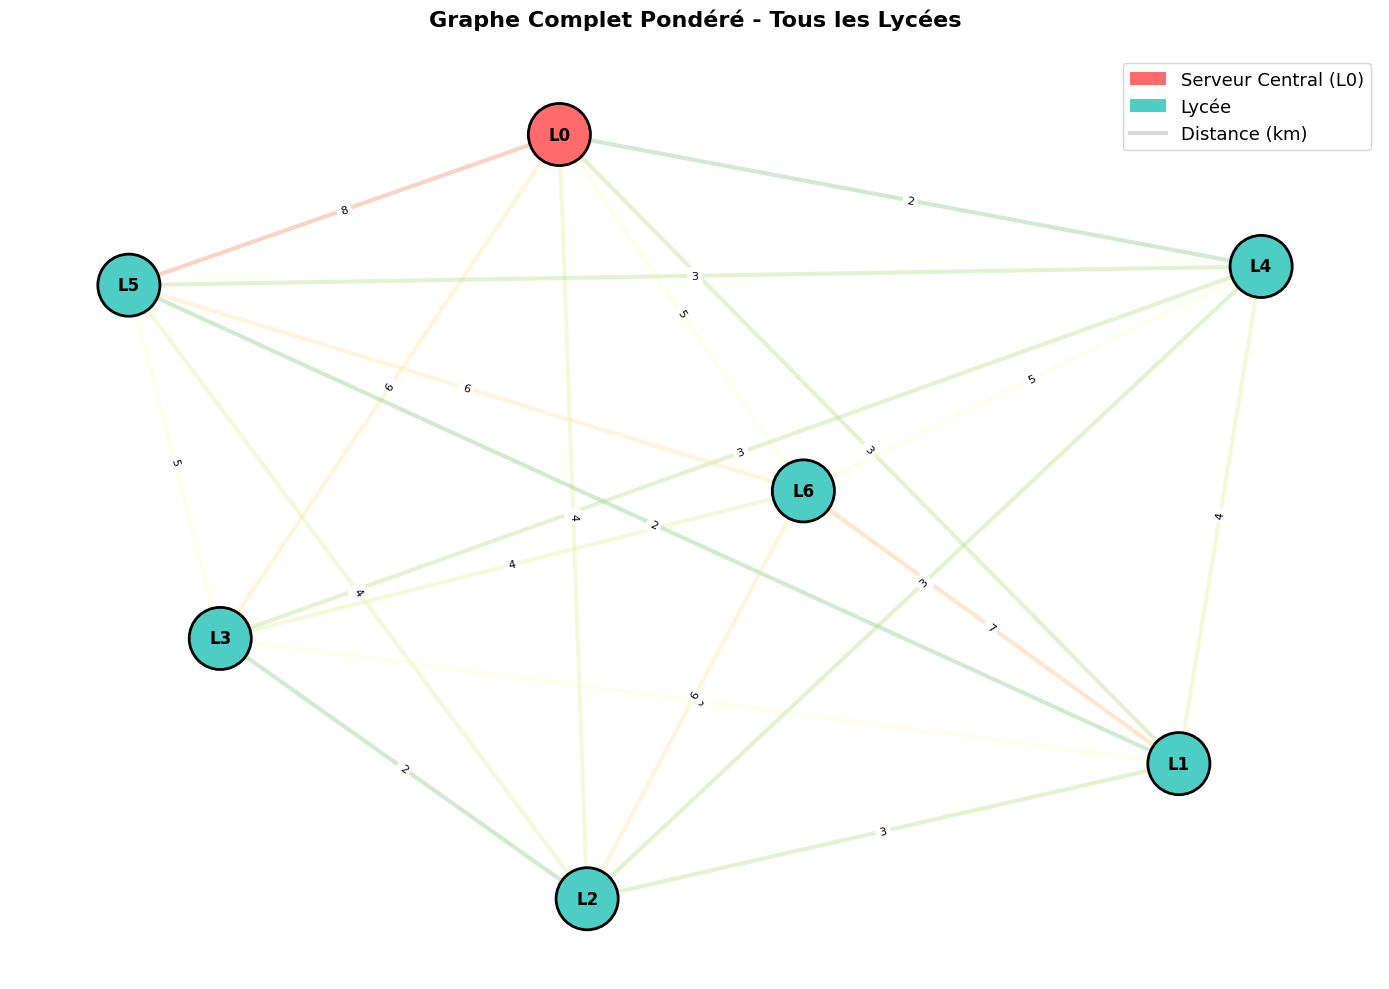


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
🔹 ÉTAPE 3 : OPTIMISATION PAR ARBRE COUVRANT MINIMAL (ACM)
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

📌 OBJECTIF
Réduire la longueur totale de fibre tout en conservant la connectivité.


 Arêtes de l'Arbre Couvrant de Minimal :
   1. L0-L4: 2 km
   2. L1-L5: 2 km
   3. L2-L3: 2 km
   4. L0-L1: 3 km
   5. L1-L2: 3 km
   6. L3-L6: 4 km

 Distance totale: 16 km
 Coût en fibre optique: 8.000.000 FCFA 



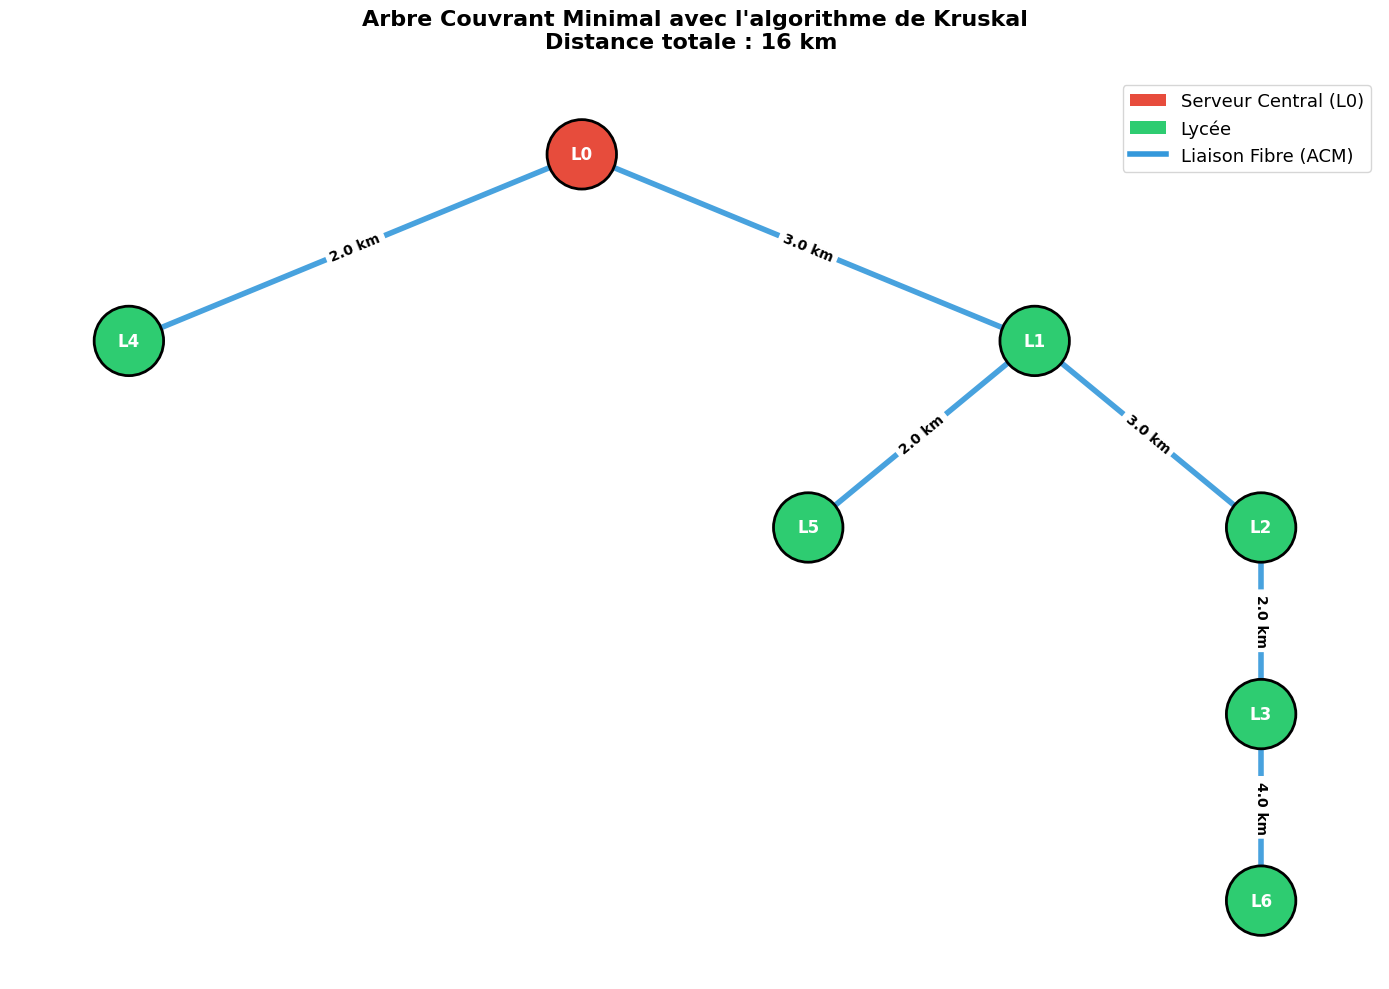


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
🔹 ÉTAPE 4 : SOLUTION HYBRIDE (FIBRE + RADIO)
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

📌 STRATÉGIE
Remplacer certaines liaisons fibre par des liaisons radio
lorsque la distance est inférieure au seuil autorisé.


Analyse de la contrainte radio:
Contrainte: Lycées à moins de 5 km du serveur L0

✅ L0 ↔ L1: 3 km (éligible)
✅ L0 ↔ L2: 4 km (éligible)
❌ L0 ↔ L3: 6 km (trop loin)
✅ L0 ↔ L4: 2 km (éligible)
❌ L0 ↔ L5: 8 km (trop loin)
❌ L0 ↔ L6: 5 km (trop loin)

Lycées éligibles pour radio: ['L1', 'L2', 'L4']

Vérification du cluster radio ['L0', 'L1', 'L2',

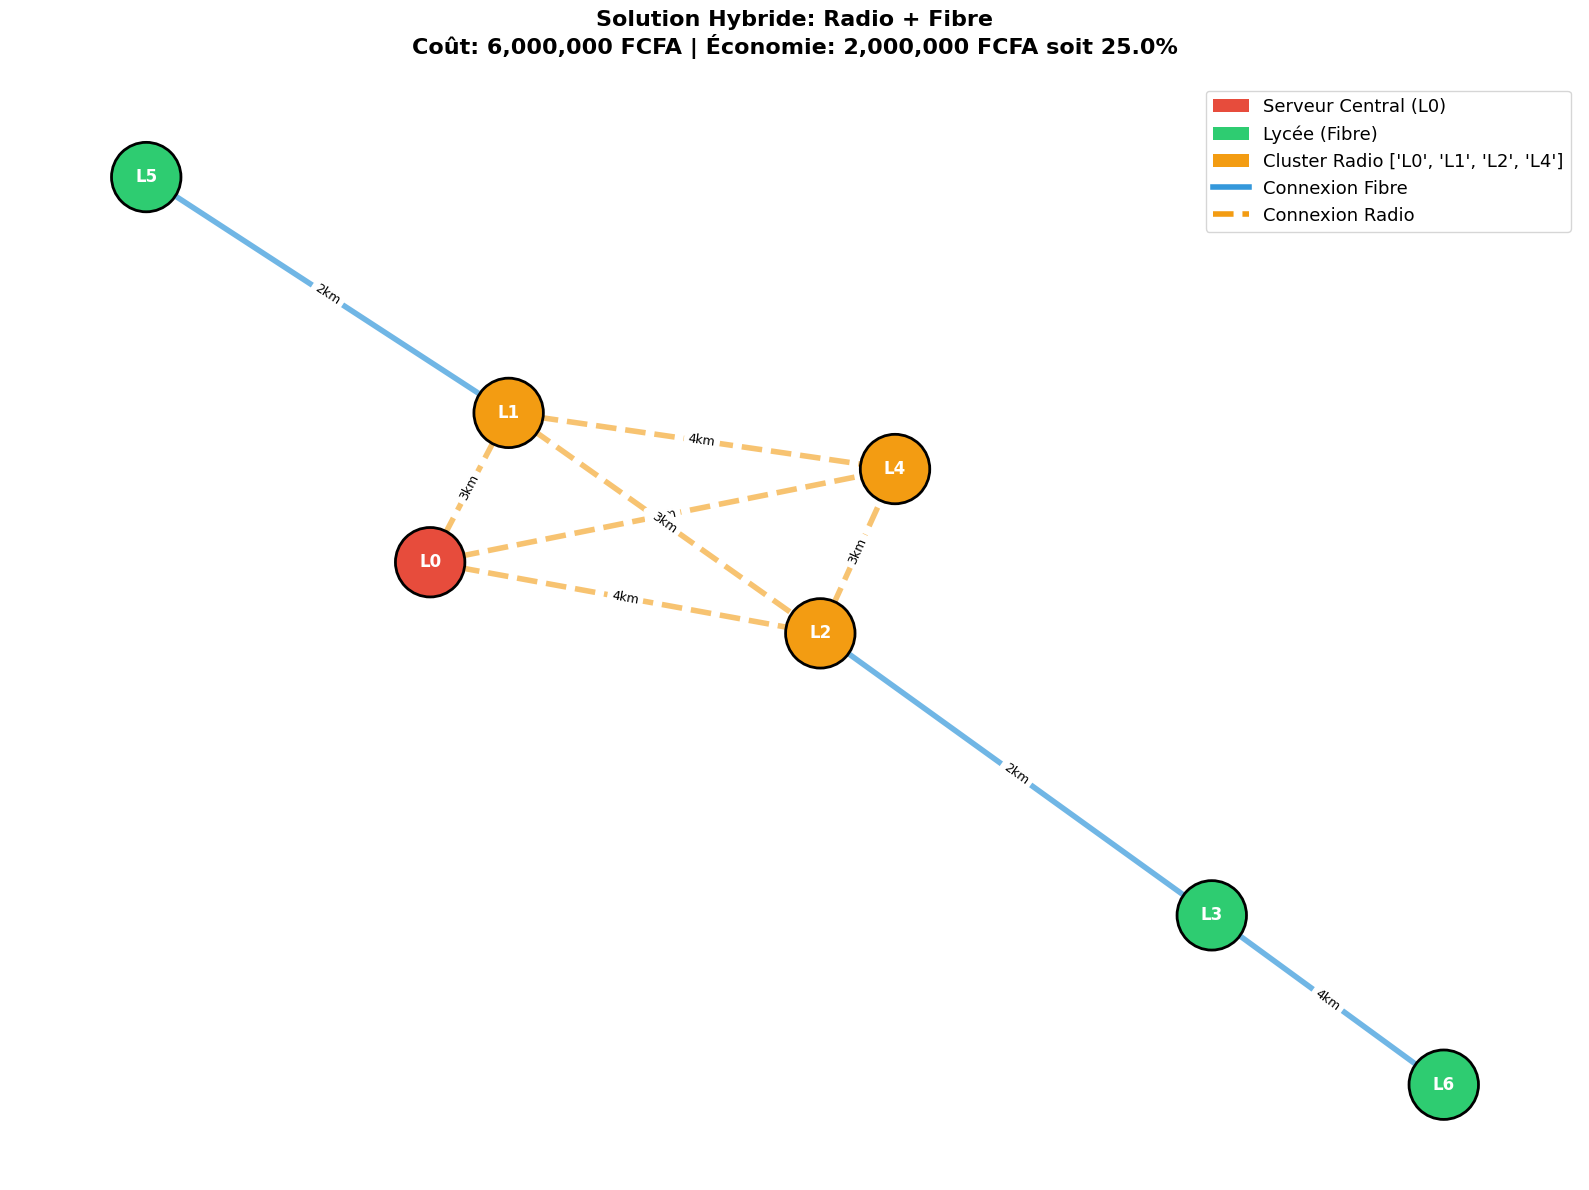


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
🔹 ÉTAPE 5 : Resultat et analyse
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

📊 TABLEAU COMPARATIF DES SOLUTIONS:

            Critère Solution Tout Fibre  Solution Hybride
        Technologie    Fibre uniquement   1 Radio + Fibre
Distance fibre (km)                  16                 8
   Nombre de radios                   0                 1
  Coût fibre (FCFA)           8,000,000         4,000,000
  Coût radio (FCFA)                   0         2,000,000
  COÛT TOTAL (FCFA)           8,000,000         6,000,000
    Économie (FCFA)                   - 2

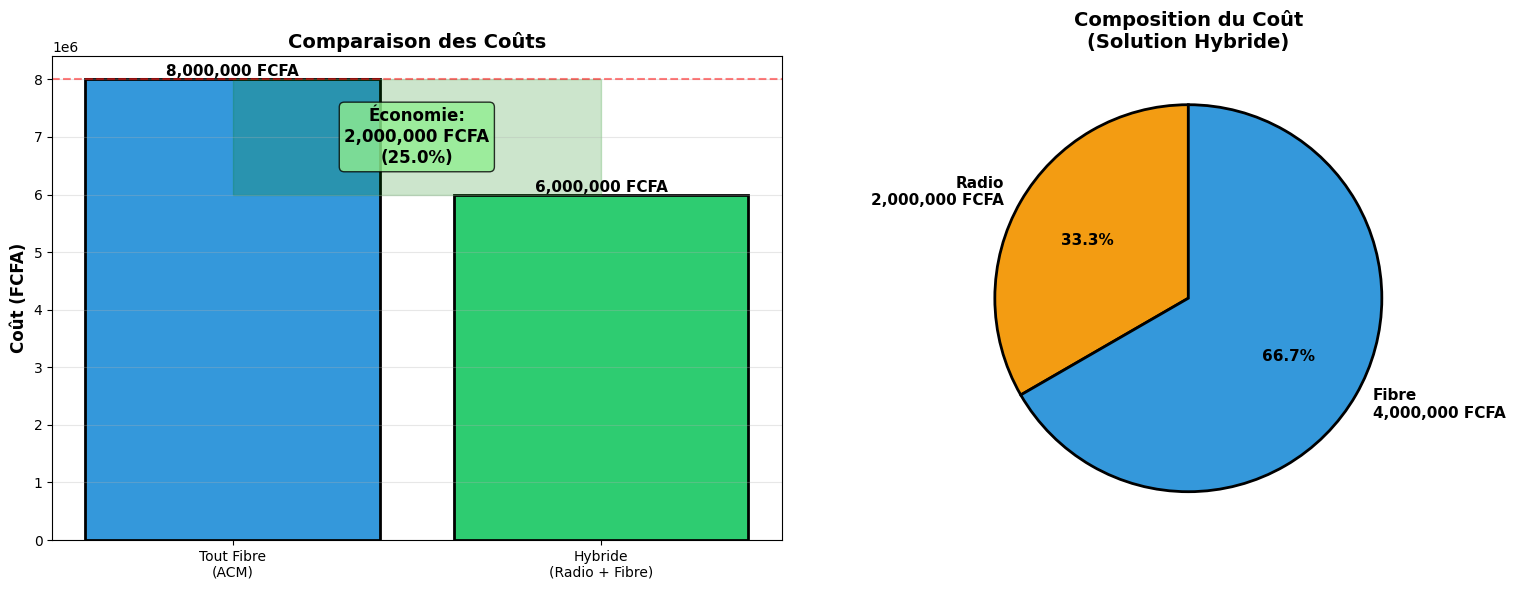


════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
✅ PROJET TERMINÉ — SOLUTION OPTIMISÉE AVEC SUCCÈS
════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════


In [178]:
################################################ Deroulement de toute l'etude #############################################################

print("\n" + "═"*240)
print(f"{RED_BOLD}  PROJET : CONNECTIVITÉ DES LYCÉES À UN SERVEUR CENTRAL{RESET}")
print("═"*240)

print(f"\n{BLACK_BOLD}🎯 OBJECTIF DU PROJET{RESET}")
print("Assurer la connexion de plusieurs lycées à un serveur central (L0)")
print("tout en minimisant les coûts d’infrastructure réseau.\n")

print(f"{BLACK_BOLD}📌 TECHNOLOGIES ÉTUDIÉES{RESET}")
print(" • Fibre optique")
print(" • Liaison radio")

############################################# Modelisation
print("\n" + "─"*240)
print(f"{RED_BOLD}🔹 ÉTAPE 1 : MODÉLISATION DU PROBLÈME{RESET}")
print("─"*240)

######## Initialisation des données
lycees_info, labels, distance_matrix, COUT_FIBRE_PAR_KM, COUT_RADIO_PAIRE, SEUIL_RADIO = modelisation()

print(f"\n{BLACK_BOLD}📌 STRUCTURE DU RÉSEAU{RESET}")
print(" • L0 représente le serveur central")
print(f" • Lycées considérés : {labels}")

print(f"\n{BLACK_BOLD}📌 MATRICE DES DISTANCES (en km){RESET}\n")
df_distances = pd.DataFrame(distance_matrix, index=labels, columns=labels)
print(df_distances)

print("\n" + "─"*240)
print(f"{RED_BOLD}🔹 ÉTAPE 2 : CONSTRUCTION DU GRAPHE COMPLET{RESET}")
print("─"*240)

print(f"\n{BLACK_BOLD}📌 PRINCIPE{RESET}")
print("Chaque lycée est connecté à tous les autres.")
print("Le poids des arêtes correspond à la distance (en km).")

######## Representation graphe complet
G_complet, aretes_completes = creer_graphes(
    labels,
    lycees_info,
    distance_matrix,
    type_graphe='complet'
)

print(f"\n{BLACK_BOLD}📊 VISUALISATION DU GRAPHE COMPLET{RESET}")

fig, ax, pos = visualiser_graphe(G_complet, "complet")
dessiner_aretes(G_complet, pos, "complet")
dessiner_noeuds(G_complet, pos, "complet")
dessiner_labels(G_complet, pos, "complet")
afficher_legende("complet")
finaliser_affichage("complet")

############################################# Arbre couvrant de poids minimal
print("\n" + "─"*240)
print(f"{RED_BOLD}🔹 ÉTAPE 3 : OPTIMISATION PAR ARBRE COUVRANT MINIMAL (ACM){RESET}")
print("─"*240)

print(f"\n{BLACK_BOLD}📌 OBJECTIF{RESET}")
print("Réduire la longueur totale de fibre tout en conservant la connectivité.\n")

######## Calcul des distance et cout de l'ACM
result_acm = calculer_distance_cout(
    G_complet,
    COUT_FIBRE_PAR_KM,
    COUT_RADIO_PAIRE,
    type_graphe='acm'
)

######## Representation ACM
G_acm = creer_graphes(
    labels,
    lycees_info,
    distance_matrix,
    type_graphe='acm'
)

fig, ax, pos_acm = visualiser_graphe(G_acm, "acm", root="L0")
dessiner_aretes(G_acm, pos_acm, "acm")
dessiner_noeuds(G_acm, pos_acm, "acm")
dessiner_labels(G_acm, pos_acm, "acm", result_acm['acm_edges'])
afficher_legende("acm")
finaliser_affichage("acm", result_acm['distance_totale_acm'])

############################################# Optimisation avec liaison onde radio
print("\n" + "─"*240)
print(f"{RED_BOLD}🔹 ÉTAPE 4 : SOLUTION HYBRIDE (FIBRE + RADIO){RESET}")
print("─"*240)

print(f"\n{BLACK_BOLD}📌 STRATÉGIE{RESET}")
print("Remplacer certaines liaisons fibre par des liaisons radio")
print("lorsque la distance est inférieure au seuil autorisé.\n")

######## Determination des sommets eligibles pour la liaison radio
cluster_radio, valid_cluster = determiner_cluster_radio(
    labels,
    distance_matrix,
    SEUIL_RADIO
)

######## Etude avec les sommets eligible
res_hybride = construire_solution_hybride(
    result_acm['acm_edges'],
    cluster_radio,
    result_acm['cout_fibre_acm'],
    COUT_RADIO_PAIRE,
    COUT_FIBRE_PAR_KM
)

######## Representation graphe hybride
G_hybride = creer_graphes(
    labels,
    lycees_info,
    distance_matrix,
    cluster_radio=cluster_radio,
    edges_fibre_kept=res_hybride['edges_fibre_kept'],
    type_graphe='hybride'
)

print(f"\n{BLACK_BOLD}📊 VISUALISATION DE LA SOLUTION HYBRIDE{RESET}")

fig, ax, pos_hybride = visualiser_graphe(G_hybride, "hybride")
dessiner_aretes(G_hybride, pos_hybride, "hybride")
dessiner_noeuds(G_hybride, pos_hybride, "hybride", cluster_radio)
dessiner_labels(G_hybride, pos_hybride, "hybride")
afficher_legende("hybride",cluster_radio)

finaliser_affichage(
    "hybride",
    result_acm['distance_totale_acm'],
    res_hybride['cout_total_hybride'],
    res_hybride['economie'],
    res_hybride['economie_pct']
)

############################################# Resultat et analyse de l'etude
print("\n" + "─"*240)
print(f"{RED_BOLD}🔹 ÉTAPE 5 : Resultat et analyse{RESET}")
print("─"*240)
resultat_analyse(
    G_hybride,
    labels,
    result_acm['distance_totale_acm'],
    res_hybride['distance_fibre_hybride'],
    result_acm['cout_fibre_acm'],
    res_hybride['cout_fibre_hybride'],
    res_hybride['cout_radio'],
    res_hybride['cout_total_hybride'],
    res_hybride['economie'],
    res_hybride['economie_pct']
)

print("\n" + "═"*240)
print(f"{RED_BOLD}✅ PROJET TERMINÉ — SOLUTION OPTIMISÉE AVEC SUCCÈS{RESET}")
print("═"*240)
